# basic data understanding

In [1]:
import sys
sys.path.append('..')

In [2]:
from src.utils import load_data
df = load_data('../data/00_raw/BrentOilPrices.csv')

In [3]:
df.head()

,Date,Price
0,20-May-87,18.63
1,21-May-87,18.45
2,22-May-87,18.55
3,25-May-87,18.60
4,26-May-87,18.63


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9011 entries, 0 to 9010
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    9011 non-null   object 
 1   Price   9011 non-null   float64
dtypes: float64(1), object(1)
memory usage: 140.9+ KB


In [5]:
df.describe()

,Price
count,9011.000000
mean,48.420782
std,32.860110
min,9.100000
25%,19.050000
50%,38.570000
75%,70.090000
max,143.950000


In [6]:
import re

# Regular expressions for date formats
ddmmyy_pattern = re.compile(r'^\d{2}-[A-Za-z]{3}-\d{2}$')
mmddyy_pattern = re.compile(r'^[A-Za-z]{3} \d{2}, \d{4}$')

ddmmyy_count = df['Date'].apply(lambda x: bool(ddmmyy_pattern.match(x))).sum()
mmddyy_count = df['Date'].apply(lambda x: bool(mmddyy_pattern.match(x))).sum()

print(f"ddmmyy format count: {ddmmyy_count}")
print(f"mmddyy format count: {mmddyy_count}")

ddmmyy format count: 8360
mmddyy format count: 651


In [7]:
other_format_count = (~df['Date'].apply(lambda x: bool(ddmmyy_pattern.match(x)) or bool(mmddyy_pattern.match(x)))).sum()
print(f"Other format count: {other_format_count}")

Other format count: 0


### Data Understanding Insights

- The dataset contains 9,011 rows with two columns: `Date` and `Price`.
- All entries in both columns are non-null, indicating no missing data.
- The `Date` column contains dates in two formats:
    - `ddmmyy` format (e.g., `20-May-87`): 8,360 entries.
    - `mmddyy` format (e.g., `Nov 08, 2022`): 651 entries.
- There are no dates in other formats (`other_format_count = 0`), ensuring consistency in date representation.
- The `Price` column is of type `float64`, suitable for numerical analysis.
- This initial exploration confirms the dataset is clean and ready for further preprocessing, such as standardizing date formats for time series analysis.

# Eda and exploration

In [8]:
# --- Core Libraries ---
import pandas as pd
import numpy as np

# --- Visualization Libraries ---
import matplotlib.pyplot as plt
import seaborn as sns

# --- Statistical Testing Library ---
from statsmodels.tsa.stattools import adfuller

In [9]:
# --- Set plot style for aesthetics ---
sns.set_style("whitegrid")

In [10]:
# The 'Date' column has mixed formats. pandas.to_datetime is smart enough to handle this
# if we clean the strings first. Some dates might have extra quotes.
df['Date'] = df['Date'].str.replace('"', '')

# Convert the cleaned 'Date' column to datetime objects
df['Date'] = pd.to_datetime(df['Date'])

# Set the 'Date' column as the index of the DataFrame
df = df.set_index('Date').sort_index()

print("--- Cleaned Data Head ---")
print(df.tail())
print("\n--- Date Range ---")
print(f"Data ranges from {df.index.min().date()} to {df.index.max().date()}")

C:\Users\user\AppData\Local\Temp\ipykernel_14172\1524034400.py:6: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Date'] = pd.to_datetime(df['Date'])


--- Cleaned Data Head ---
            Price
Date             
2022-11-08  96.85
2022-11-09  93.05
2022-11-10  94.25
2022-11-11  96.37
2022-11-14  93.59

--- Date Range ---
Data ranges from 1987-05-20 to 2022-11-14


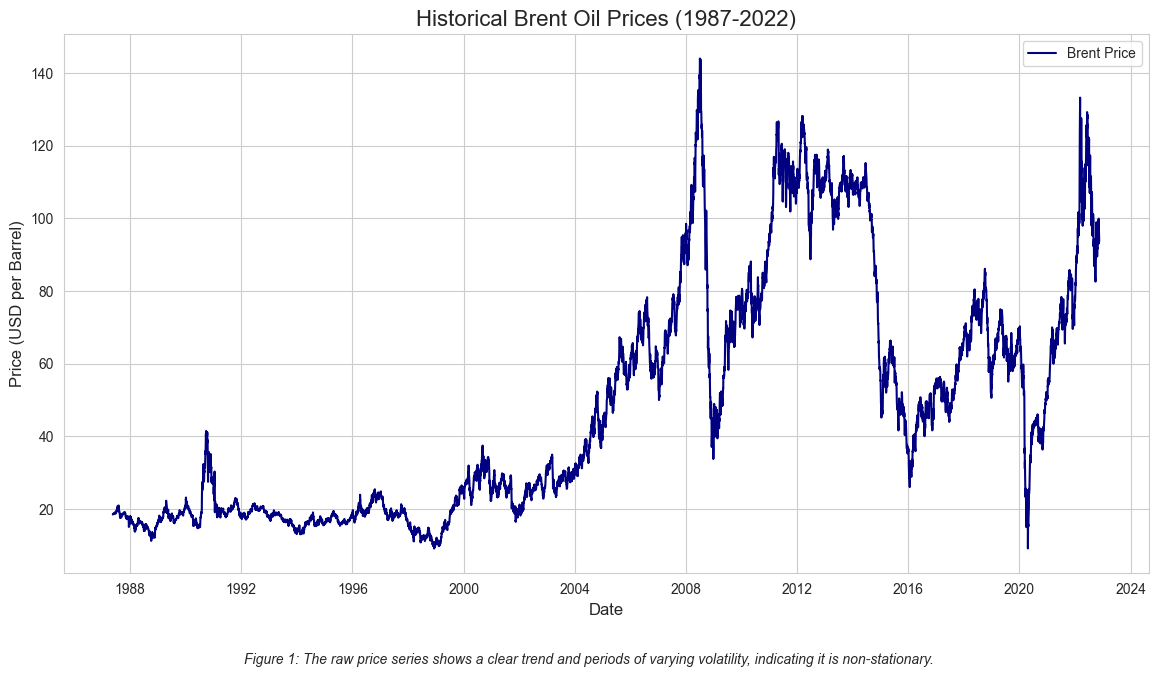

In [11]:
# Plot the raw price series
plt.figure(figsize=(14, 7))
plt.plot(df['Price'], label='Brent Price', color='navy')
plt.title('Historical Brent Oil Prices (1987-2022)', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price (USD per Barrel)', fontsize=12)
plt.legend()
plt.figtext(0.5, -0.02, 'Figure 1: The raw price series shows a clear trend and periods of varying volatility, indicating it is non-stationary.',
             ha='center', fontsize=10, style='italic')
plt.show()

In [12]:
adf_result_raw = adfuller(df['Price'].dropna())

print('--- ADF Test on Raw Price Data ---')
print(f'ADF Statistic: {adf_result_raw[0]}')
print(f'p-value: {adf_result_raw[1]}')
print('Critical Values:')
for key, value in adf_result_raw[4].items():
    print(f'\t{key}: {value}')

# Interpretation
if adf_result_raw[1] > 0.05:
    print("\nResult: The p-value is greater than 0.05. We fail to reject the null hypothesis.")
    print("The raw price series is NON-STATIONARY.")
else:
    print("\nResult: The p-value is less than or equal to 0.05. We reject the null hypothesis.")
    print("The raw price series is STATIONARY.")

--- ADF Test on Raw Price Data ---
ADF Statistic: -1.993856011392467
p-value: 0.2892735048934032
Critical Values:
	1%: -3.4310783342658615
	5%: -2.861861876398633
	10%: -2.566941329781918

Result: The p-value is greater than 0.05. We fail to reject the null hypothesis.
The raw price series is NON-STATIONARY.


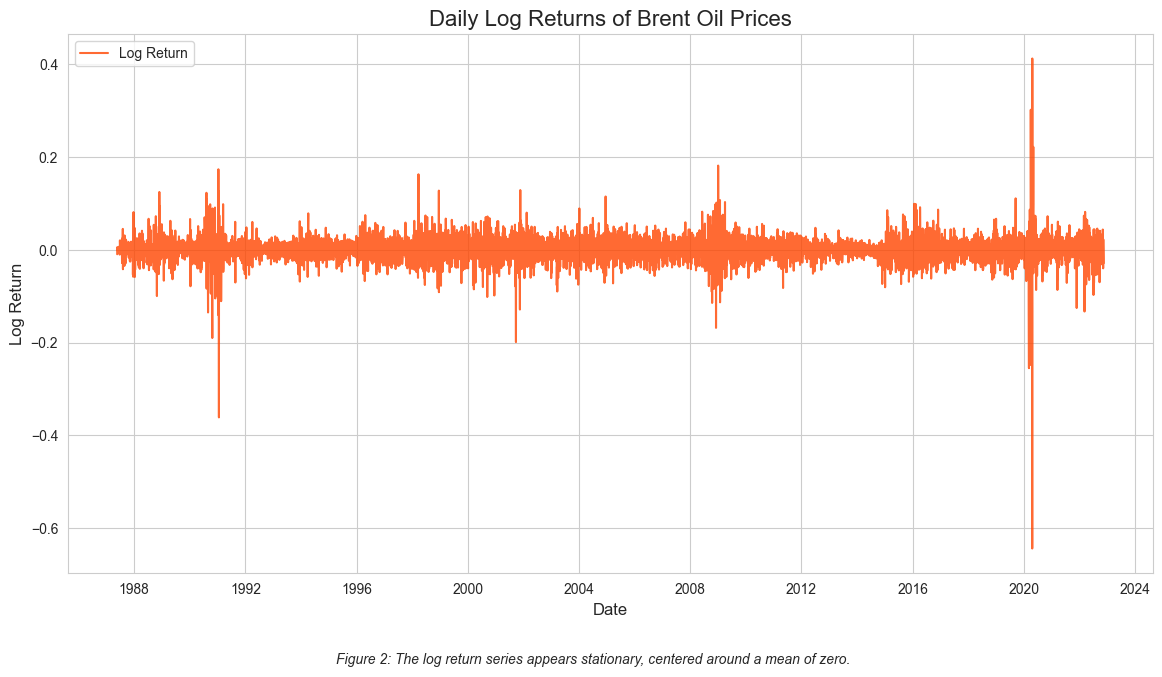

In [13]:
df['Log_Return'] = np.log(df['Price']).diff()

# Plot the log returns
plt.figure(figsize=(14, 7))
plt.plot(df['Log_Return'], label='Log Return', color='orangered', alpha=0.8)
plt.title('Daily Log Returns of Brent Oil Prices', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Log Return', fontsize=12)
plt.legend()
plt.figtext(0.5, -0.02, 'Figure 2: The log return series appears stationary, centered around a mean of zero.',
             ha='center', fontsize=10, style='italic')
plt.show()

In [14]:
adf_result_log = adfuller(df['Log_Return'].dropna())

print('--- ADF Test on Log Return Data ---')
print(f'ADF Statistic: {adf_result_log[0]}')
print(f'p-value: {adf_result_log[1]}')
print('Critical Values:')
for key, value in adf_result_log[4].items():
    print(f'\t{key}: {value}')

# Interpretation
if adf_result_log[1] > 0.05:
    print("\nResult: The p-value is greater than 0.05. We fail to reject the null hypothesis.")
    print("The log return series is NON-STATIONARY.")
else:
    print("\nResult: The p-value is less than or equal to 0.05. We reject the null hypothesis.")
    print("The log return series is STATIONARY.")

--- ADF Test on Log Return Data ---
ADF Statistic: -16.42711349448589
p-value: 2.4985801611428892e-29
Critical Values:
	1%: -3.4310783342658615
	5%: -2.861861876398633
	10%: -2.566941329781918

Result: The p-value is less than or equal to 0.05. We reject the null hypothesis.
The log return series is STATIONARY.


## Summary of the Notebook

This notebook provides an exploratory data analysis (EDA) and initial preprocessing of historical Brent Oil Prices data. The workflow includes:

- **Data Loading & Inspection:**  
    The dataset is loaded using a custom utility function and basic statistics (`head`, `info`, `describe`) are reviewed. The data contains 9,011 rows with two columns: `Date` and `Price`, and no missing values.

- **Date Format Analysis:**  
    Regular expressions are used to identify two date formats in the `Date` column:  
    - `ddmmyy` (e.g., `20-May-87`): 8,360 entries  
    - `mmddyy` (e.g., `Nov 08, 2022`): 651 entries  
    No entries are found in other formats, ensuring consistency.

- **Data Cleaning & Preparation:**  
    The `Date` column is cleaned and converted to datetime objects, then set as the DataFrame index. The data is sorted chronologically.

- **Visualization:**  
    - The raw price series is plotted, showing clear trends and periods of volatility.
    - Daily log returns are calculated and visualized, appearing stationary and centered around zero.

- **Stationarity Testing:**  
    - Augmented Dickey-Fuller (ADF) tests are performed:
        - **Raw Price Series:** Non-stationary (ADF Statistic: -1.99, p-value: 0.29)
        - **Log Return Series:** Stationary (ADF Statistic: -16.43, p-value: 2.50e-29)

- **Key Insights:**  
    - The dataset is clean and well-structured for time series analysis.
    - The price series is non-stationary, while log returns are stationary, which is typical for financial time series.
    - The notebook sets the stage for further modeling and forecasting tasks.

---

**Variables of Interest:**  
- `df`: Cleaned DataFrame with `Price` and `Log_Return` columns, indexed by date  
- `adf_result_raw`, `adf_result_log`: Results of ADF tests for stationarity  
- `ddmmyy_count`, `mmddyy_count`, `other_format_count`: Counts of date formats in the dataset

In [15]:
df.head()

,Price,Log_Return
Date,,
1987-05-20,18.63,NaN
1987-05-21,18.45,-0.009709
1987-05-22,18.55,0.005405
1987-05-25,18.60,0.002692
1987-05-26,18.63,0.001612


In [16]:
from src.utils import save_data
save_data(df, '../data/01_processed/BrentOilPrices_Cleaned.csv')